# Variational Autoencoder

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))

    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [14]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()
        
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])
        
        #print(self.z_mean.shape, self.z_log_sigma_sq.shape)
        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps)

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_recog_3,
                            n_hidden_gener_1,  n_hidden_gener_2, n_hidden_gener_3,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'h3': tf.Variable(xavier_init(n_hidden_recog_2, n_hidden_recog_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_3, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_3, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_recog_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'h3': tf.Variable(xavier_init(n_hidden_gener_2, n_hidden_gener_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_3, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_3, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_gener_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder 
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        z_mean         = tf.add(tf.matmul(layer_3, weights['out_mean']),
                                biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_3, weights['out_log_sigma']), 
                                biases['out_log_sigma'])
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['out_mean']), 
                                        biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # Two loss:
        #
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        
        
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        # average over batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [6]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Reconstruction quality

In [7]:
network_architecture = \
    dict(n_hidden_recog_1=400, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=100, # 3th layer encoder neurons
         n_hidden_gener_1=100, # 1st layer decoder neurons
         n_hidden_gener_2=200, # 2nd layer decoder neurons
         n_hidden_gener_3=400, # 3th layer decoder neurons
         n_input=784,          # MNIST data input (img shape: 28*28)
         n_z=20)               # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 191.697856029
Epoch: 0006 cost= 119.581707708
Epoch: 0011 cost= 111.801994379
Epoch: 0016 cost= 108.194179355
Epoch: 0021 cost= 106.098230771
Epoch: 0026 cost= 104.622305589
Epoch: 0031 cost= 103.528397120
Epoch: 0036 cost= 102.750087003
Epoch: 0041 cost= 102.063823533
Epoch: 0046 cost= 101.602718686
Epoch: 0051 cost= 101.085888575
Epoch: 0056 cost= 100.686894850
Epoch: 0061 cost= 100.346071736
Epoch: 0066 cost= 100.053383428
Epoch: 0071 cost= 99.769087663


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those.

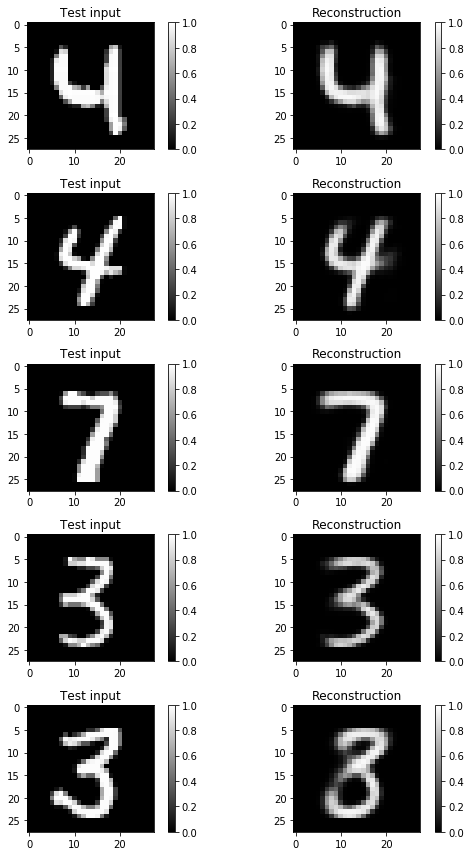

In [8]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Latent space

In [9]:
x_sample[0].shape

(784,)

In [15]:
network_architecture = \
    dict(n_hidden_recog_1=100, # 1st layer encoder neurons
         n_hidden_recog_2=50, # 2nd layer encoder neurons
         n_hidden_recog_3=20, # 3th layer encoder neurons
         n_hidden_gener_1=20, # 1st layer decoder neurons
         n_hidden_gener_2=50, # 2nd layer decoder neurons
         n_hidden_gener_3=100, # 3th layer decoder neurons
         n_input=784,          # MNIST data input (img shape: 28*28)
         n_z=2)                # dimensionality of latent space

vae_2d = train(network_architecture, learning_rate = 0.001, training_epochs=85)

Epoch: 0001 cost= 200.532909379
Epoch: 0006 cost= 158.442680498
Epoch: 0011 cost= 152.221844815
Epoch: 0016 cost= 148.250714278
Epoch: 0021 cost= 146.355880793
Epoch: 0026 cost= 144.734591952
Epoch: 0031 cost= 143.214269922
Epoch: 0036 cost= 142.146059806
Epoch: 0041 cost= 141.459677499
Epoch: 0046 cost= 140.542724693
Epoch: 0051 cost= 140.178041715
Epoch: 0056 cost= 139.719432581
Epoch: 0061 cost= 138.985545696
Epoch: 0066 cost= 138.939777707
Epoch: 0071 cost= 138.422118780
Epoch: 0076 cost= 138.128147361
Epoch: 0081 cost= 137.822278123


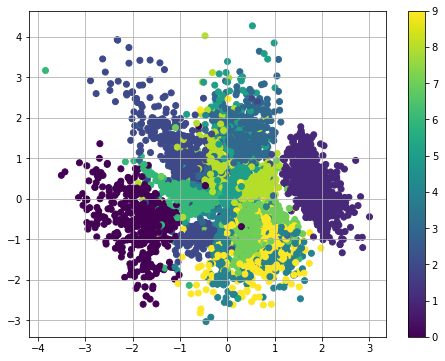

In [16]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

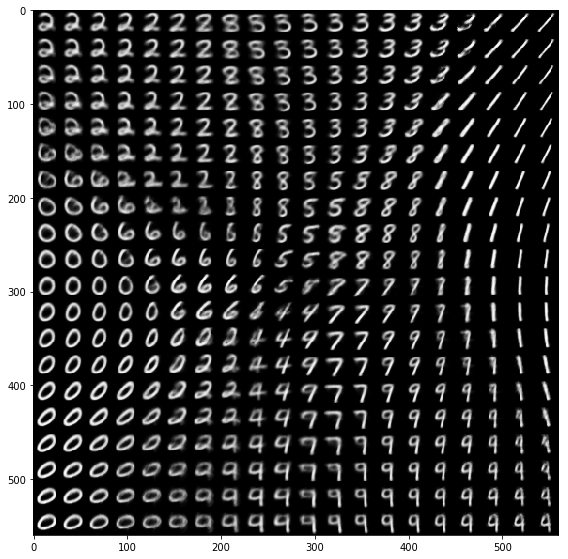

In [18]:
nx = ny = 20
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [19]:
CLASSES  = 10
nx       = 10 
ny       = 10
N        = nx * ny

samples  = np.zeros((CLASSES, N , 2))

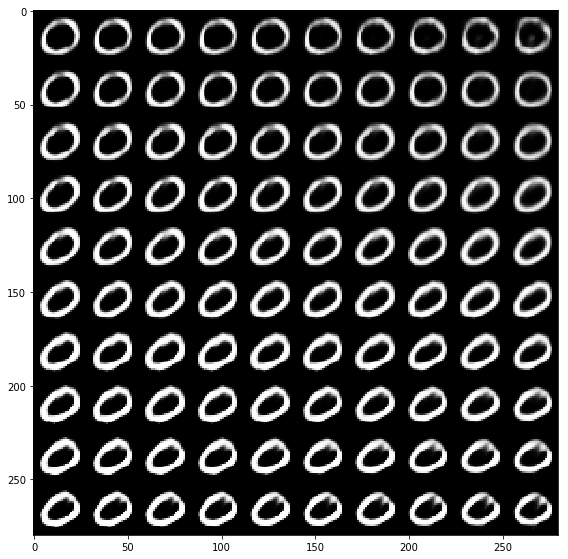

In [40]:
# ZERO
x_values = np.linspace(  -4,  1.5, nx)
y_values = np.linspace( -5, -3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[0][i * CLASSES + j][0] = xi
        samples[0][i * CLASSES + j][1] = yi

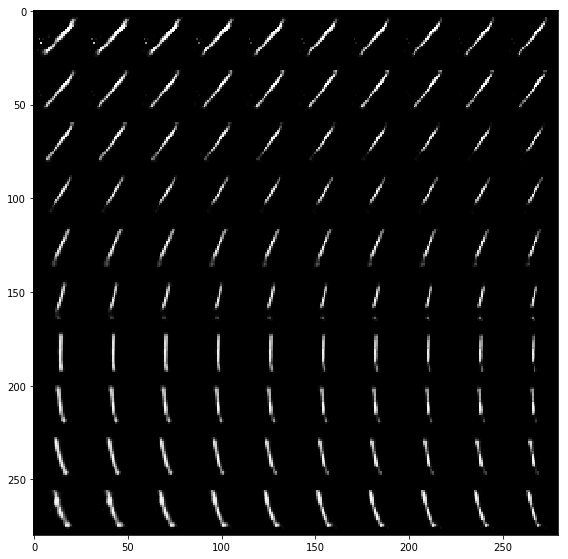

In [44]:
# ONE
x_values = np.linspace(  -2,  3.5, nx)
y_values = np.linspace(   3,  4, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[1][i * CLASSES + j][0] = xi
        samples[1][i * CLASSES + j][1] = yi

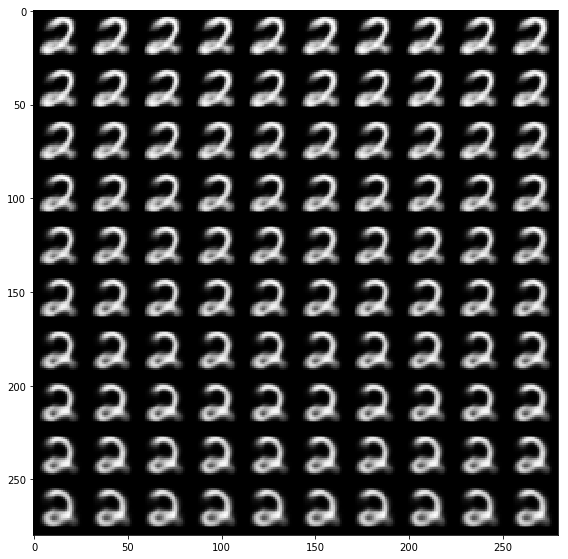

In [49]:
# TWO
x_values = np.linspace(  2,  4, nx)
y_values = np.linspace( -2.0,  -2.0, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[2][i * CLASSES + j][0] = xi
        samples[2][i * CLASSES + j][1] = yi

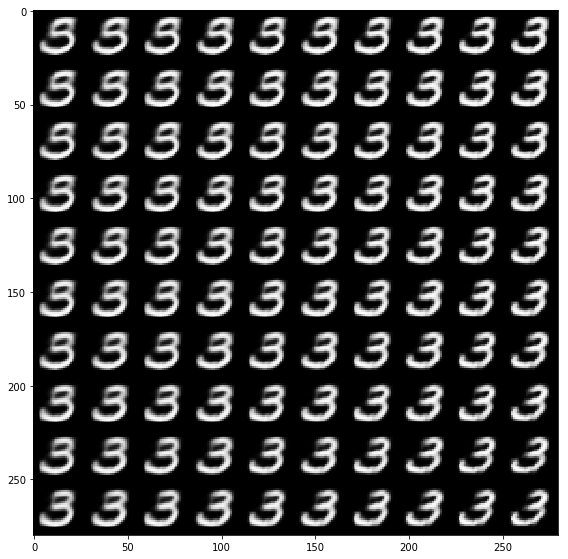

In [56]:
# THREE
x_values = np.linspace(  3.0,  4.0, nx)
y_values = np.linspace(  1.0,  1.5, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[3][i * CLASSES + j][0] = xi
        samples[3][i * CLASSES + j][1] = yi

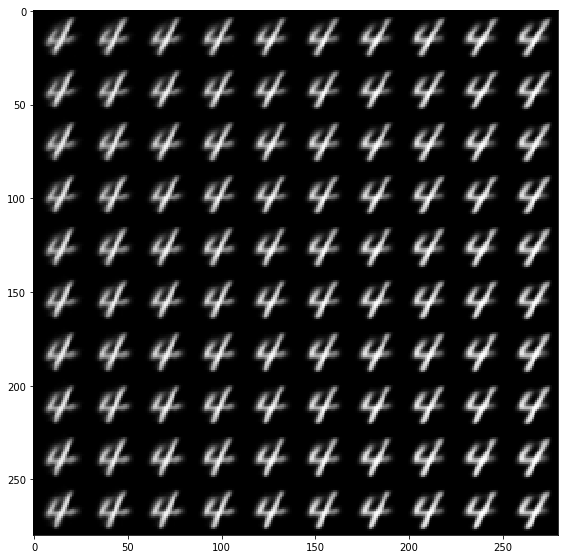

In [78]:
# FOUR
x_values = np.linspace( -0.5,  -0.4, nx)
y_values = np.linspace( -0.2,  0.0, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[4][i * CLASSES + j][0] = xi
        samples[4][i * CLASSES + j][1] = yi

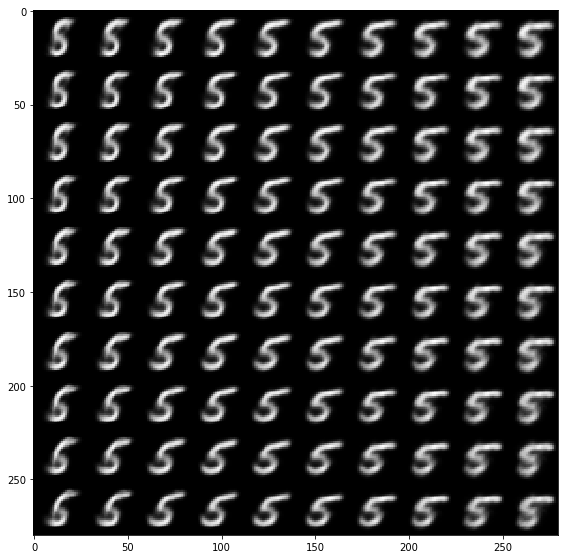

In [87]:
# FIVE

x_values = np.linspace(  0.1,  0.3, nx)
y_values = np.linspace( -0.2,  0.2, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

x_values = np.linspace( 3,  5, nx)
y_values = np.linspace( 0,  1.0, ny)

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[5][i * CLASSES + j][0] = xi
        samples[5][i * CLASSES + j][1] = yi

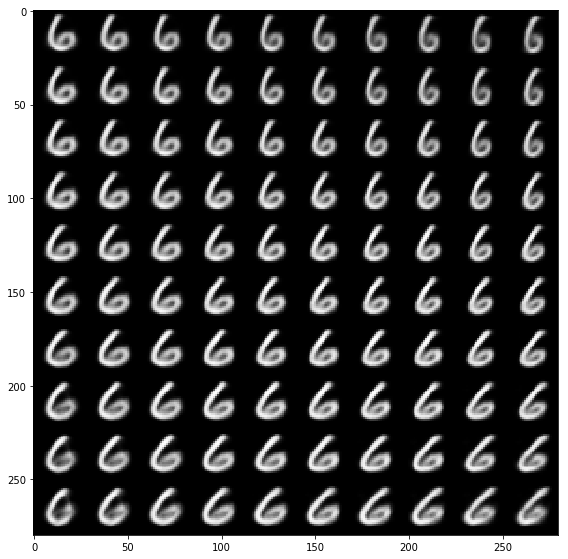

In [95]:
# SIX
x_values = np.linspace(  -0.3,  0.2, nx)
y_values = np.linspace(  -1.0,  -0.5, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[6][i * CLASSES + j][0] = xi
        samples[6][i * CLASSES + j][1] = yi

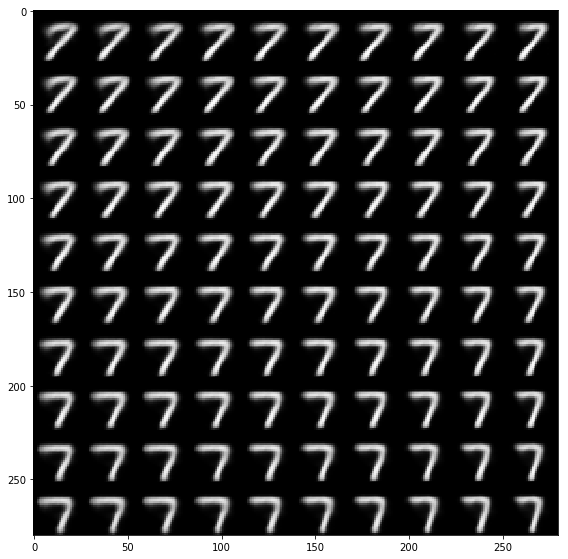

In [108]:
# SEVEN
x_values = np.linspace(  -1.0,  -0.3, nx)
y_values = np.linspace(   0.3,  0.5, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[7][i * CLASSES + j][0] = xi
        samples[7][i * CLASSES + j][1] = yi

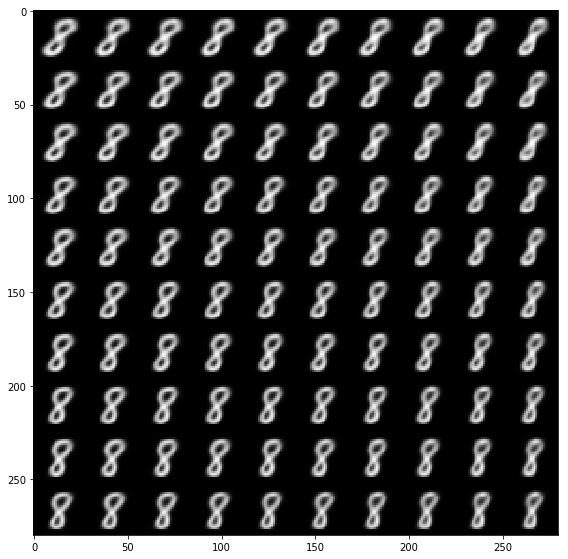

In [122]:
# EIGHT
x_values = np.linspace(  0.2, 0.8, nx)
y_values = np.linspace(  0.8, 1.0, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[8][i * CLASSES + j][0] = xi
        samples[8][i * CLASSES + j][1] = yi

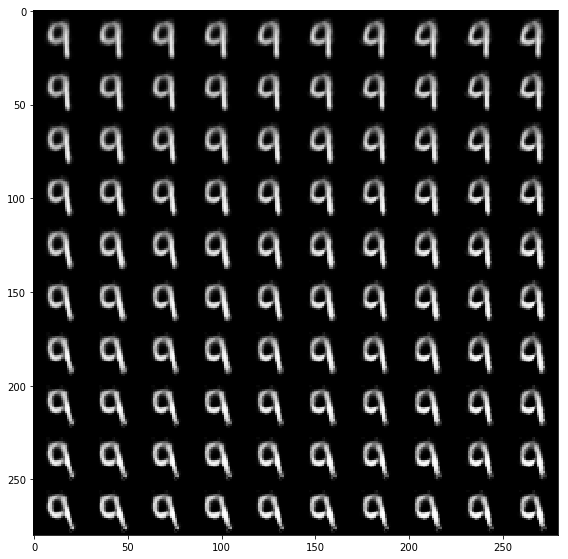

In [128]:
# NINE
x_values = np.linspace( -4, -2, nx)
y_values = np.linspace(  1, 1.5, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        samples[9][i * CLASSES + j][0] = xi
        samples[9][i * CLASSES + j][1] = yi

In [141]:
import numpy as np

np.save('samples.npy', samples)

In [143]:
samples = np.load('samples.npy')

In [129]:
def getImg(s):
    number = int(input_text)
    rn     = np.random.randint(N)
    z_mu   = np.array([samples[number][rn]]*vae.batch_size)
    x_mean = vae_2d.generate(z_mu)
 
    img    = x_mean[0].reshape(28, 28) 
    
    return img

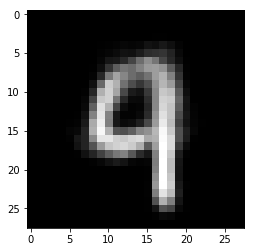

In [142]:
input_text = '9'
img = getImg(input_text)
plt.imshow(img, cmap="gray")

In [244]:
def getListOfNumbers(sNUM):
    res = []
    for i in range(len(sNUM)):
        img = getImg(sNUM[i])
        res.append(img)
    return res

In [247]:
NUM = input("Enter a number : ")

Enter a number : 56489


In [248]:
input_imgs = getListOfNumbers(NUM)

In [249]:
len(input_imgs)

5

In [250]:
input_imgs[0].shape

(28, 28)

In [251]:
type(input_imgs[0])

numpy.ndarray